In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
# import warnings
# warnings.filterwarnings('ignore')
# %matplotlib inline

import cv2
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

/home/raphaelpeabody/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-05-13 15:01:20.632067: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 15:01:20.677826: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compile

In [2]:
model_path = 'only_white.h5'

In [3]:
data = "/home/raphaelpeabody/Downloads/UTKFace"

In [4]:
image_paths = []
age_labels = []
gender_labels = []
race_labels = []

for filename in tqdm(os.listdir(data)):
    image_path = os.path.join(data, filename)
    try:
        temp = filename.split('_')
        age = int(temp[0])
        gender = int(temp[1])
        race = int(temp[2])
    except ValueError:
        print("Skipping file:", filename)
        continue
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)



  0%|          | 0/23709 [00:00<?, ?it/s]

Skipping file: rename.bash
Skipping file: 39_1_20170116174525125.jpg
Skipping file: 61_1_20170109150557335.jpg
Skipping file: 61_1_20170109142408075.jpg


In [5]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race'] = image_paths, age_labels, gender_labels, race_labels
df.head()

,image,age,gender,race
0,/home/raphaelpeabody/Downloads/UTKFace/7_1_4_2...,7,1,4
1,/home/raphaelpeabody/Downloads/UTKFace/26_1_0_...,26,1,0
2,/home/raphaelpeabody/Downloads/UTKFace/18_1_0_...,18,1,0
3,/home/raphaelpeabody/Downloads/UTKFace/22_1_3_...,22,1,3
4,/home/raphaelpeabody/Downloads/UTKFace/28_1_0_...,28,1,0


In [6]:
gender_dict = {0:'Male', 1:'Female'}
race_dict = {0:'White', 1:'Black', 2:'Asian', 3:'Indian', 4:'Other'}

## feature extraction

In [7]:
X = np.load('../X.npy')

## model setup

In [8]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
y_race = np.array(df['race'])

In [9]:
from sklearn.model_selection import train_test_split

# Dictionary to store datasets for each race
datasets_per_race = {}

# Split the dataset based on race
unique_races = np.unique(y_race)
for race in race_dict:
    race_indices = np.where(y_race == race)[0]
    X_race = X[race_indices]
    y_age_race = y_age[race_indices]
    y_gender_race = y_gender[race_indices]
    print(len(X_race))
    print(len(y_age_race))
    print(len(y_gender_race))
    # Split the race dataset into train and test sets
    # X_train, X_test, y_train, y_test = train_test_split(X_race, y_age_race, test_size=0.2, random_state=42)

    print(f"Race: {race_dict[race]}")
    print(f"Number of samples: {len(X_race)}")

    # # Plot the age distribution for each race
    # plt.figure()
    # plt.hist(y_age_race, bins=20, edgecolor='black')
    # plt.title(f"Age Distribution for {race_dict[race]}")
    # plt.xlabel("Age")
    # plt.ylabel("Frequency")
    # plt.show()

    datasets_per_race[race_dict[race]] = {'X': X_race, 'y': y_age_race, 'gender': y_gender_race}

10078
10078
10078
Race: White
Number of samples: 10078
4526
4526
4526
Race: Black
Number of samples: 4526
3434
3434
3434
Race: Asian
Number of samples: 3434
3975
3975
3975
Race: Indian
Number of samples: 3975
1692
1692
1692
Race: Other
Number of samples: 1692


Race: Male
Number of samples: 12391


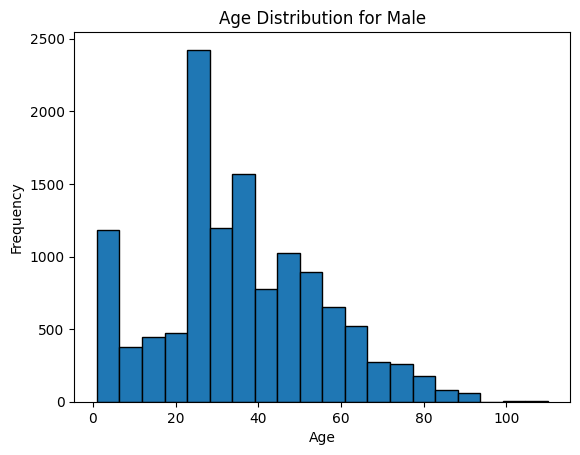

Race: Female
Number of samples: 11314


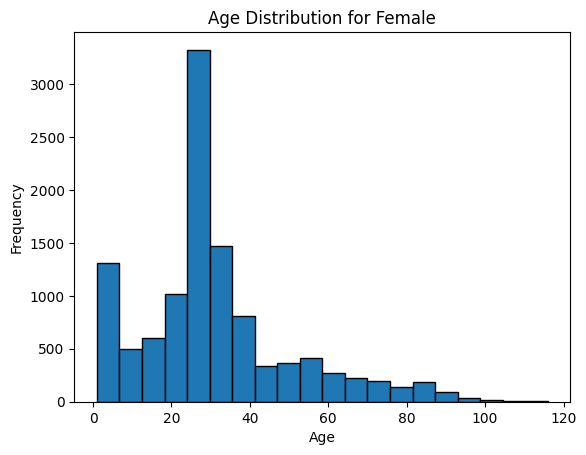

In [10]:
# Dictionary to store datasets for each race
datasets_per_gender = {}

# Split the dataset based on race
unique_genders = np.unique(y_gender)
for gender in gender_dict:
    gender_indices = np.where(y_gender == gender)[0]
    X_gender = X[gender_indices]
    y_age_gender = y_age[gender_indices]
    y_gender_gender = y_gender[gender_indices]
    # print(len(X_race))
    # print(len(y_age_race))
    # print(len(y_gender_race))
    # Split the race dataset into train and test sets
    # X_train, X_test, y_train, y_test = train_test_split(X_race, y_age_race, test_size=0.2, random_state=42)

    print(f"Race: {gender_dict[gender]}")
    print(f"Number of samples: {len(X_gender)}")

    # Plot the age distribution for each race
    plt.figure()
    plt.hist(y_age_gender, bins=20, edgecolor='black')
    plt.title(f"Age Distribution for {gender_dict[gender]}")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.show()


    datasets_per_gender[gender_dict[gender]] = {'X': X_gender, 'y': y_age_gender, 'gender': y_gender_gender}

In [11]:
from tensorflow.keras.models import load_model

def mae(y_true, y_pred):
    return tf.keras.losses.mean_absolute_error(y_true, y_pred)

model = load_model(model_path, custom_objects={'mae': mae})

2024-05-13 15:01:30.164552: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-13 15:01:30.261077: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
from sklearn.metrics import mean_absolute_error
from scipy import stats

# Calculate MAE for each race dataset using the original model
mae_per_race_dataset = {}
for race, data in datasets_per_race.items():
    X_test_race = data['X']
    y_test_race = data['y']

    # Predict age using the original model
    y_pred_race = model.predict(X_test_race)

    # Calculate MAE
    mae_race = mean_absolute_error(y_test_race, y_pred_race)
    mae_per_race_dataset[race] = mae_race

# Print MAE for each race dataset
for race, mae in mae_per_race_dataset.items():
    print(f"MAE for {race}: {mae}")

315/315 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
MAE for White: 5.969676030902877
MAE for Black: 8.57726950568801
MAE for Asian: 7.179325578305773
MAE for Indian: 7.144275494296596
MAE for Other: 5.82009718355769


In [13]:
from sklearn.metrics import mean_absolute_error
from scipy import stats

# Calculate MAE for each race dataset using the original model
mae_per_gender_dataset = {}
for gender, data in datasets_per_gender.items():
    X_test_gender = data['X']
    y_test_gender = data['y']

    # Predict age using the original model
    y_pred_gender = model.predict(X_test_gender)

    # Calculate MAE
    mae_gender = mean_absolute_error(y_test_gender, y_pred_gender)
    mae_per_gender_dataset[gender] = mae_gender

# Print MAE for each race dataset
for gender, mae in mae_per_gender_dataset.items():
    print(f"MAE for {gender}: {mae}")

388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step
MAE for Male: 6.801323380441222
MAE for Female: 6.859450448598777


: 